# Analisis de modelo

Técnica inteligente llamada Keyword Extraction (TF-IDF) para ver qué palabras distinguen a las anomalías de los predios normales.

## Imports y Configuración

In [5]:
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Descargar stopwords (palabras vacías como "el", "la", "de")
nltk.download("stopwords")
spanish_stopwords = stopwords.words("spanish")

# Añadir palabras técnicas comunes que no aportan valor
custom_stop = [
    "numero",
    "escritura",
    "notaria",
    "registro",
    "matricula",
    "fecha",
    "municipio",
    "departamento",
    "año",
    "bogota",
    "valor",
    "pesos",
]
spanish_stopwords.extend(custom_stop)

# Añadir path local
sys.path.append("../src")
from utils.config import PROCESSED_DATA_DIR

print("✅ Librerías de NLP cargadas.")

✅ Librerías de NLP cargadas.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Cargar Anomalías y Datos Normales

In [ ]:
print("📦 Cargando y Preparando datos de anomalías...")

# 1. Cargar Anomalías (Solo lo básico primero)
# Quitamos "TIPO_ANOMALIA" del select porque no existe aún
anomalies_file = PROCESSED_DATA_DIR / "igac_anomalies_detected.parquet"
lf_anom = pl.scan_parquet(anomalies_file)

# 2. Cargar Texto y datos necesarios para reclasificar
# Necesitamos VALOR y NUM_ANOTACION para recrear las etiquetas
lf_std = pl.scan_parquet(PROCESSED_DATA_DIR / "igac_standardized.parquet")
df_full = pl.concat(
    [lf_std, lf_anom.select(["ES_ANOMALIA", "SCORE_ANOMALIA"])], how="horizontal"
).collect()

# 3. Re-crear la columna TIPO_ANOMALIA (Igual que en el notebook anterior)
df_full = df_full.with_columns(
    pl.when(pl.col("VALOR_CONSTANTE_2024") > 10_000_000_000)
    .then(pl.lit("VALOR_EXTREMO"))
    .when(pl.col("VALOR_CONSTANTE_2024") < 1_000_000)
    .then(pl.lit("VALOR_INFIMO"))
    .when(pl.col("NUM_ANOTACION") > 50)
    .then(pl.lit("TRAFICO_JURIDICO_INUSUAL"))
    .otherwise(pl.lit("OTRO_PATRON"))
    .alias("TIPO_ANOMALIA")
)

# 4. Filtrar textos no nulos
df_full = df_full.filter(pl.col("DOCUMENTO_JUSTIFICATIVO").is_not_null())

# 5. Separar grupos para NLP
# Tomamos solo los de "OTRO_PATRON" y "TRAFICO" para el análisis profundo, o todas las anomalías
txt_anomalias = df_full.filter(pl.col("ES_ANOMALIA") == 1)[
    "DOCUMENTO_JUSTIFICATIVO"
].to_list()

# Muestra de normales del mismo tamaño
txt_normales = (
    df_full.filter(pl.col("ES_ANOMALIA") == 0)
    .sample(n=len(txt_anomalias))["DOCUMENTO_JUSTIFICATIVO"]
    .to_list()
)

print(f"✓ Datos listos y re-etiquetados.")
print(f"   Anomalías con texto: {len(txt_anomalias)}")
print(f"   Normales con texto: {len(txt_normales)}")

📦 Cargando y Preparando datos de anomalías...
✓ Datos listos y re-etiquetados.
   Anomalías con texto: 57661
   Normales con texto: 57661


## Análisis de Frecuencia (Nube de Palabras Lógica)

In [8]:
def get_top_words(text_list, n=20):
    # Unir todo el texto
    text = " ".join(str(t).lower() for t in text_list)
    # Tokenizar (separar palabras)
    words = [
        w
        for w in text.split()
        if w.isalpha() and w not in spanish_stopwords and len(w) > 3
    ]
    return Counter(words).most_common(n)


print("🔍 Analizando vocabulario...")
top_anom = get_top_words(txt_anomalias)
top_norm = get_top_words(txt_normales)

# Crear DataFrame para comparar
df_freq = pd.DataFrame(
    {
        "Palabra_Anomala": [w[0] for w in top_anom],
        "Frec_Anomala": [w[1] for w in top_anom],
        "Palabra_Normal": [w[0] for w in top_norm],
        "Frec_Normal": [w[1] for w in top_norm],
    }
)

print("\n--- Top Palabras en Transacciones ANÓMALAS vs NORMALES ---")
print(df_freq.head(15))

🔍 Analizando vocabulario...

--- Top Palabras en Transacciones ANÓMALAS vs NORMALES ---
   Palabra_Anomala  Frec_Anomala Palabra_Normal  Frec_Normal
0            unica         13171          unica        11795
1          segunda          5396        segunda         6691
2          tercera          5359        primera         4609
3    villavicencio          5188        tercera         4455
4          primera          3880    bucaramanga         2549
5        cartagena          3381         cuarta         2532
6           cuarta          2065        pereira         2419
7     barranquilla          2040         quinta         2043
8      bucaramanga          1754         ibague         1929
9         monteria          1649      manizales         1893
10           pasto          1616         cucuta         1889
11        medellin          1349          pasto         1737
12          cucuta          1238      cartagena         1606
13          ibague          1231          santa         14

## Detección de Palabras Clave de Fraude (TF-IDF)

In [9]:
print("🧠 Calculando importancia de palabras (TF-IDF)...")

# Crear corpus (Grupo 1: Anomalías, Grupo 2: Normales)
corpus = [
    " ".join(str(t) for t in txt_anomalias),
    " ".join(str(t) for t in txt_normales),
]

# Calcular TF-IDF
tfidf = TfidfVectorizer(stop_words=spanish_stopwords, max_features=1000)
X = tfidf.fit_transform(corpus)
feature_names = tfidf.get_feature_names_out()

# Obtener scores para Anomalías (Fila 0)
scores = X[0].T.todense()
df_scores = pd.DataFrame(scores, index=feature_names, columns=["TFIDF_Score"])
df_scores = df_scores.sort_values("TFIDF_Score", ascending=False)

print("\n--- Palabras que DEFINEN a las Anomalías ---")
print(df_scores.head(20))

🧠 Calculando importancia de palabras (TF-IDF)...

--- Palabras que DEFINEN a las Anomalías ---
               TFIDF_Score
00                0.861530
unica             0.183359
12                0.140804
22                0.120146
11                0.107757
21                0.107047
10                0.101145
2015              0.095062
09                0.095020
08                0.090566
03                0.089967
2016              0.089424
2017              0.088575
2018              0.087990
07                0.086807
06                0.085638
villavicencio     0.082088
05                0.080975
04                0.079764
02                0.079638


## Visualización de Hallazgos

C:\Users\carlo\AppData\Local\Temp\ipykernel_16632\30265970.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


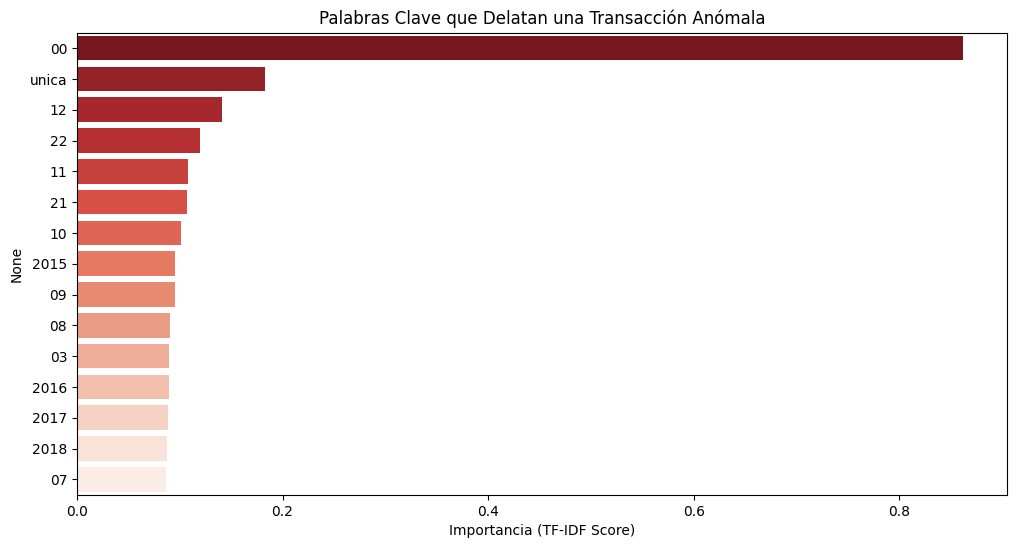

In [10]:
# Graficar las palabras distintivas de las anomalías
plt.figure(figsize=(12, 6))
sns.barplot(
    x=df_scores.head(15)["TFIDF_Score"], y=df_scores.head(15).index, palette="Reds_r"
)
plt.title("Palabras Clave que Delatan una Transacción Anómala")
plt.xlabel("Importancia (TF-IDF Score)")
plt.show()